In [ ]:
%load_ext autoreload
%autoreload 2


from liftout.structures import Sample, load_experiment


import os 
import numpy as np
import matplotlib.pyplot as plt



In [ ]:
# path = r"C:\Users\Admin\Github\autoliftout\liftout\log\dm-embryo-05_2022-08-29.11-57-03AM" # 6
path = r"C:\Users\Admin\Github\autoliftout\liftout\log\dm-embryo-06_2022-08-30.03-26-27PM" # 3

sample = load_experiment(path)
sample.__to_dataframe__()

### Log Parsing (new)

In [107]:
%load_ext autoreload
%autoreload 2
import pandas as pd
from copy import deepcopy
from dataclasses import dataclass

from pathlib import Path

from liftout.tools.data import calculate_statistics_dataframe, AutoLiftoutStatistics, calculate_aggregated_statistics


# paths = [
#     r"C:\Users\Admin\Github\autoliftout\liftout\log\dm-embryo-05_2022-08-29.11-57-03AM",
#     r"C:\Users\Admin\Github\autoliftout\liftout\log\dm-embryo-06_2022-08-30.03-26-27PM"
# ]

path = r"C:\Users\Admin\Github\autoliftout\liftout\log\dm-embryo-08-2022-10-18.10-39-45AM"
df = calculate_statistics_dataframe(path)


df.click

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,beam_type,type,x,y
0,ION,MOVEMENT,-0.000004,-0.000232
1,ION,MOVEMENT,0.000040,0.000246
2,ION,MOVEMENT,-0.000004,0.000233
3,ION,MOVEMENT,0.000015,-0.000283
4,ION,MOVEMENT,0.000065,-0.000120
...,...,...,...,...
187,ION,MILLING,0.000003,-0.000004
188,ION,MILLING,0.000002,-0.000004
189,ION,MILLING,0.000001,-0.000004
190,ION,MILLING,-0.000010,-0.000003


In [ ]:
df = calculate_aggregated_statistics(paths)
display(df)

In [ ]:
# specimen current
microscope.state.specimen_current.value

## System Settings
Set / Restore system settings


In [ ]:
%load_ext autoreload
%autoreload 2
from fibsem import utils, calibration
from fibsem.structures import BeamSystemSettings, SystemSettings, BeamType

from autoscript_sdb_microscope_client import SdbMicroscopeClient

from pprint import pprint 

In [ ]:
microscope, settings = utils.setup_session()

In [ ]:
eb_settings = calibration.get_current_beam_system_state(microscope, BeamType.ELECTRON)
ib_settings = calibration.get_current_beam_system_state(microscope, BeamType.ION)
pprint(eb_settings)
pprint(ib_settings)

In [ ]:
from dataclasses import asdict
# check if settings are different
for i, (a, b) in enumerate(list(zip(asdict(eb_settings).values(), asdict(settings.system.electron).values()))):

    if a != b:
        k = list(asdict(eb_settings).keys())[i]
        print("not equal: ", k, a, b)

## History Bug

In [ ]:
%load_ext autoreload
%autoreload 2

from liftout.structures import create_experiment, Lamella, AutoLiftoutStage
from liftout.autoliftout import update_sample_lamella_data
from fibsem import utils
from pprint import pprint
from liftout import autoliftout


microscope, settings = utils.setup_session()
os.makedirs("test", exist_ok=True)
sample = create_experiment("test-history", "test")


In [ ]:
lamella = Lamella(sample.path, 1)
sample = update_sample_lamella_data(sample, lamella)

stages = [stage for stage in AutoLiftoutStage][2:]

for stage in stages:
    print(stage)
    pprint(sample)
    pprint(sample.positions[1])

    lamella.current_state.stage = stage
    sample = autoliftout.end_of_stage_update(microscope, sample, lamella, )
    
    pprint(sample)
    pprint(sample.positions[1])
    pprint([state.stage.name for state in sample.positions[1].history])
    print("-"*50)

## Initial Calibration

Set the initial grid states 

set the initial calibration (eucentric, horizontal shift, needle)

## New AutoLiftout UI

autoliftout ui in napari


In [ ]:
%load_ext autoreload
%autoreload 2

from liftout.structures import load_experiment, Sample
from autoscript_sdb_microscope_client.structures import AdornedImage
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import napari
from liftout import autoliftout

# pprint(sample)


In [ ]:
DISPLAY_REFERENCE_FNAMES = [
    "ref_lamella_low_res_ib",
    "ref_trench_high_res_ib",
    "ref_jcut_high_res_ib",
    "ref_liftout_ib",
    "ref_landing_lamella_high_res_ib",
    "ref_reset_high_res_ib",
    "ref_thin_lamella_post_superres_ib",
    "ref_polish_lamella_post_superres_ib",
]

headers = [
    "Sample No",
    "Position",
    "Reference",
    "Milling",
    "J-Cut",
    "Liftout",
    "Landing",
    "Reset",
    "Thinning",
    "Polishing",
]

In [ ]:
plt.figure(figsize=(15, 15))
plt.imshow(overview_image, cmap="gray")
plt.show()

In [ ]:
path = r"C:\Users\Admin\Github\autoliftout\liftout\log\dm-embryo-05_2022-08-29.11-57-03AM" # 6
# path = r"C:\Users\Admin\Github\autoliftout\liftout\log\dm-embryo-06_2022-08-30.03-26-27PM" # 3

from liftout.gui.utils import create_overview_image
sample = load_experiment(path)

# TODO: stage labels, lamella labels

overview_image = create_overview_image(sample)
viewer = napari.Viewer()
viewer.add_image(overview_image, name="AutoLiftout")

In [7]:

%load_ext autoreload
%autoreload 2

from fibsem import utils

microscope, settings = utils.setup_session(session_path = "xyz")

2022-10-06 11:01:26,777 — root — INFO — connect_to_microscope:31 — Microscope client connecting to [10.0.0.1]
2022-10-06 11:01:26,782 — root — INFO — connect_to_microscope:34 — Microscope client connected to [10.0.0.1]
2022-10-06 11:01:26,783 — root — INFO — setup_session:252 — Finished setup for session: demo_2022-10-06.11-01-26AM


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Client connecting to [10.0.0.1:7520]...
Client connected to [10.0.0.1:7520]


In [6]:
settings.image.save_path

'abc'

In [20]:
from gc import is_finalized
from liftout.structures import AutoLiftoutStage, load_experiment, Lamella, Sample

path = r"C:\Users\Admin\Github\autoliftout\liftout\log\dm-embryo-05_2022-08-29.11-57-03AM" # 6
# path = r"C:\Users\Admin\Github\autoliftout\liftout\log\dm-embryo-06_2022-08-30.03-26-27PM" # 3

from liftout.gui.utils import create_overview_image
sample = load_experiment(path)


def get_completion_stats(sample: Sample) -> tuple:
    """Get the current completetion stats for lifout"""    
    n_stages = AutoLiftoutStage.Polishing.value # init and failure dont count

    lam: Lamella
    active_lam = 0
    completed_stages = 0
    for lam in sample.positions.values():

        # dont count failure
        if lam.is_failure or lam.current_state.stage.value == 99:
            continue
        
        active_lam += 1
        completed_stages += lam.current_state.stage.value

    total_stages = n_stages * active_lam
    perc_complete = completed_stages / total_stages


    return n_stages, active_lam, completed_stages, total_stages, perc_complete


n_stages, active_lam, completed_stages, total_stages, perc_complete = get_completion_stats(sample)

print(completed_stages, active_lam, total_stages, perc_complete)


5 2 14 0.35714285714285715


In [1]:
%load_ext autoreload
%autoreload 2

from fibsem import utils, acquire
import matplotlib.pyplot as plt

microscope, settings = utils.setup_session()

2022-10-18 15:13:17,856 — root — INFO — connect_to_microscope:31 — Microscope client connecting to [10.0.0.1]
2022-10-18 15:13:17,862 — root — INFO — connect_to_microscope:34 — Microscope client connected to [10.0.0.1]
2022-10-18 15:13:17,862 — root — INFO — setup_session:252 — Finished setup for session: demo_2022-10-18.03-13-17PM


Client connecting to [10.0.0.1:7520]...
Client connected to [10.0.0.1:7520]


In [4]:
settings.default

DefaultSettings(imaging_current=2e-11, milling_current=2e-09)

In [13]:
from liftout import actions
from fibsem import movement
# movement.insert_needle()
actions.move_needle_to_reset_position(microscope)


2022-10-18 15:29:18,990 — root — INFO — insert_needle:38 — inserted needle to ManipulatorPosition(x=-0.00048682043, y=0.00022960291, z=0.00031581769, coordinate_system=Raw).


In [11]:
movement.retract_needle(microscope)

2022-10-18 15:27:40,640 — root — INFO — retract_multichem:43 — retracting multichem
2022-10-18 15:27:40,644 — root — INFO — retract_multichem:46 — retract multichem complete
2022-10-18 15:27:40,645 — root — INFO — retract_needle:65 — retracting needle to ManipulatorPosition(x=-0.00048682043, y=0.00022960291, z=0.017365603, coordinate_system=Raw)
2022-10-18 15:27:44,350 — root — INFO — retract_needle:79 — retracting needle...
2022-10-18 15:27:49,115 — root — INFO — retract_needle:81 — retract needle complete


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


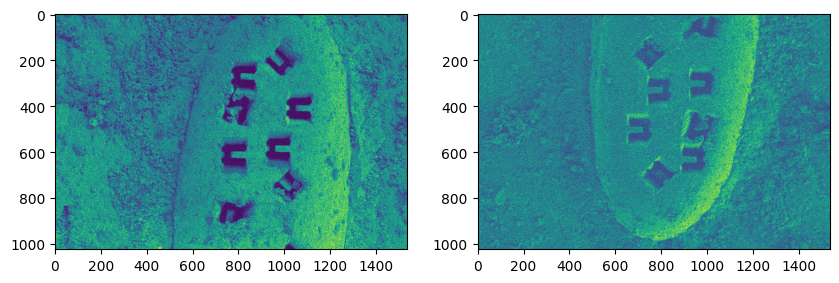

In [26]:

%load_ext autoreload
%autoreload 2

from liftout.utils import crosscorrelate_and_plot
from autoscript_sdb_microscope_client.structures import AdornedImage
import matplotlib.pyplot as plt

p1 = r"C:\Users\Admin\Github\autoliftout\liftout\log\dm-embryo-08-2022-10-18.10-39-45AM\02-next-bison/2022-10-18.02-10-48PM_eb.tif"
p2 = r"C:\Users\Admin\Github\autoliftout\liftout\log\dm-embryo-08-2022-10-18.10-39-45AM\02-next-bison/ref_trench_low_res_ib.tif"

img1 = AdornedImage.load(p1)
img2 = AdornedImage.load(p2)


fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img1.data)
ax[1].imshow(img2.data)
plt.show()



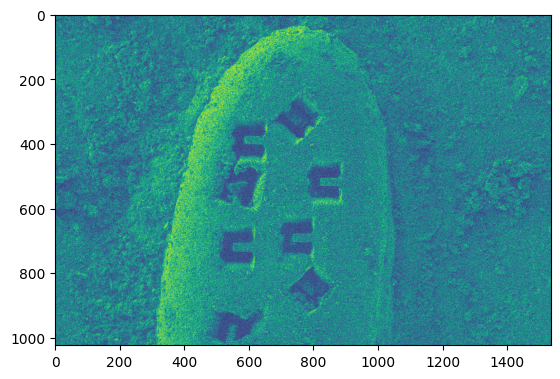

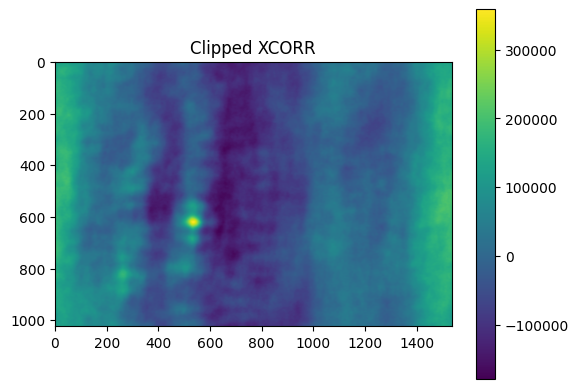

shift_m: 6.0677161e-05, -2.864587e-05
shift_px: 233, -110


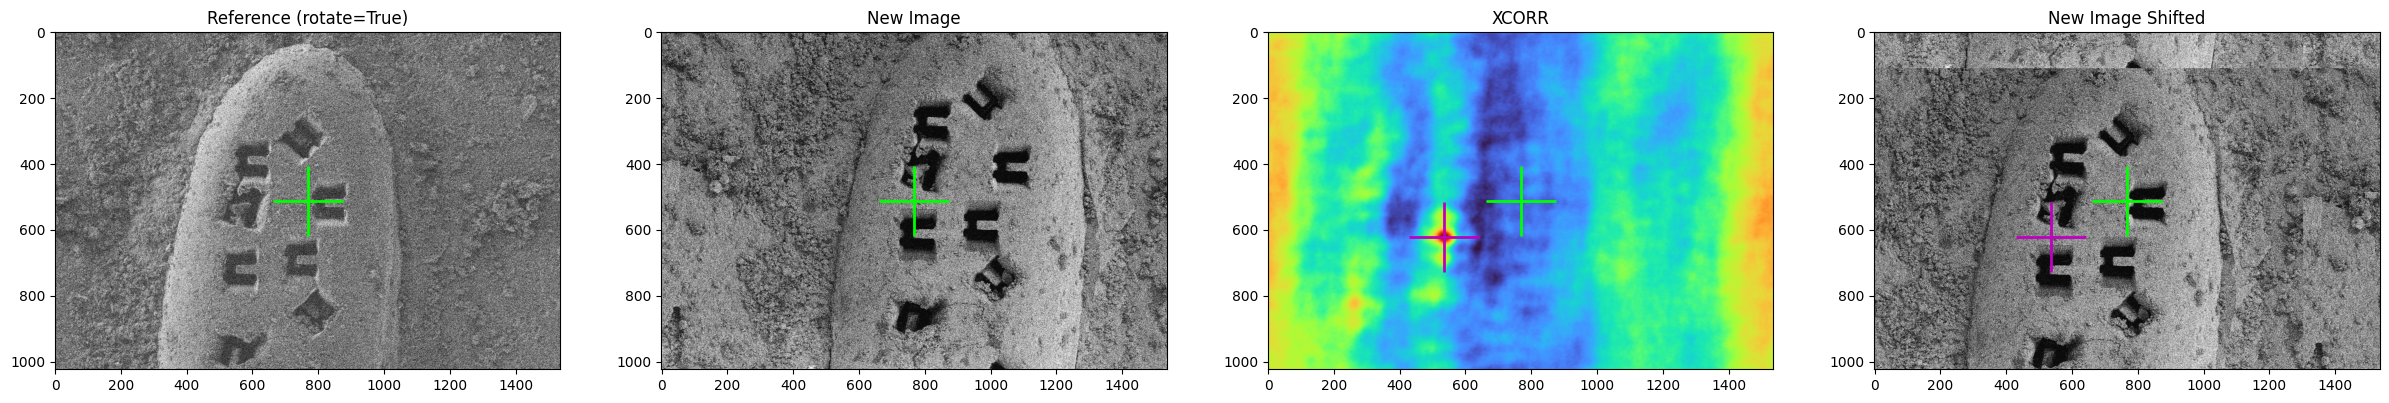

(6.0677161e-05,
 -2.864587e-05,
 array([[120889.45195542, 121313.28396851, 121829.71817722, ...,
         120722.70500981, 120544.18309882, 120615.31948723],
        [120443.09793814, 121207.14318886, 122062.90719982, ...,
         119427.78602045, 119489.14760383, 119847.21716753],
        [120308.80218219, 121283.207239  , 122352.25733175, ...,
         118737.29747867, 118968.1415611 , 119512.3754335 ],
        ...,
        [122862.85622834, 122303.33563895, 121822.96078811, ...,
         124766.01357613, 124109.37968453, 123471.92384938],
        [122233.83090662, 121918.06493611, 121692.37852411, ...,
         123724.60198947, 123132.16142345, 122637.80198091],
        [121533.28040113, 121568.17603708, 121696.49738065, ...,
         122278.6892382 , 121860.05711691, 121620.91555015]]))

In [69]:
from fibsem.utils import setup_session, load_settings_from_config
from liftout.config import config
from fibsem.imaging import masks
from fibsem.imaging import utils as image_utils

settings = load_settings_from_config(
    config_path = config.config_path,
    protocol_path = config.protocol_path
)


plt.imshow(image_utils.rotate_image(img2).data)
plt.show()

# ref_mask = masks.create_lamella_mask(image_utils.rotate_image(img2), settings.protocol["lamella"], scale = 4, use_trench_height=True) # TODO: refactor, liftout specific

crosscorrelate_and_plot(img2, img1, rotate=True)

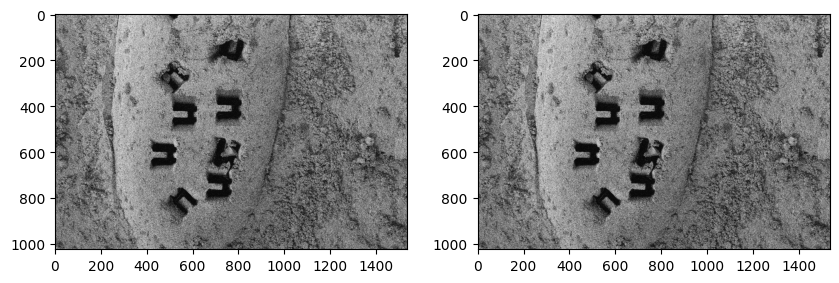

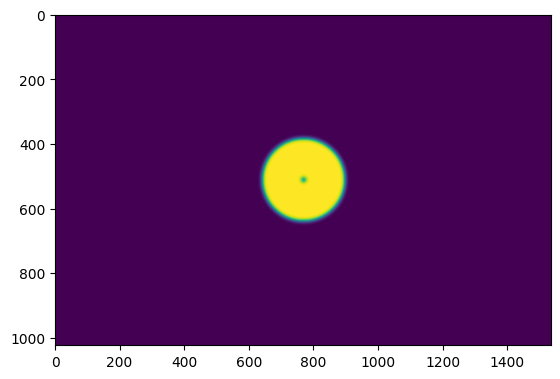

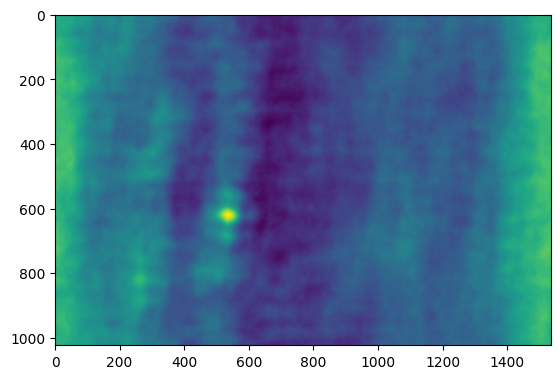

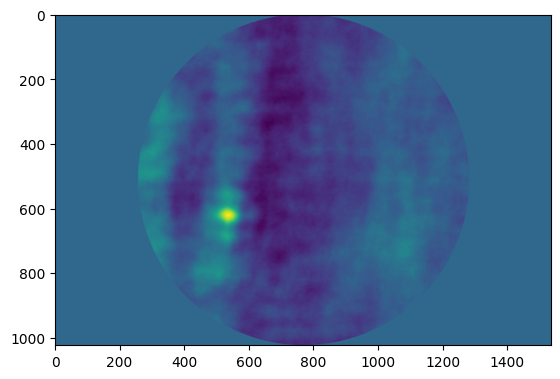

In [68]:
from fibsem import alignment


# rotate 
img1_r = image_utils.rotate_image(img1)


# normalise images
img1_norm = image_utils.normalise_image(img1_r.data)
img2_norm = image_utils.normalise_image(img2.data)

# create bandpass
lp=128
hp=6
sigma =6
bandpass = masks.create_bandpass_mask(shape=img1_norm.shape, lp=lp, hp=hp, sigma=sigma)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img1_norm, cmap="gray")
ax[1].imshow(img1_norm, cmap="gray")
plt.show()

plt.imshow(bandpass)
plt.show()

# crosscorrelation
xcorr = alignment.crosscorrelation_v2(img1_norm, img2_norm, bandpass=bandpass)
plt.imshow(xcorr)
plt.show()

xcorr = masks.apply_circular_mask(xcorr, 512)
plt.imshow(xcorr)
plt.show()



h: 115, w:95
h: 576, w:480


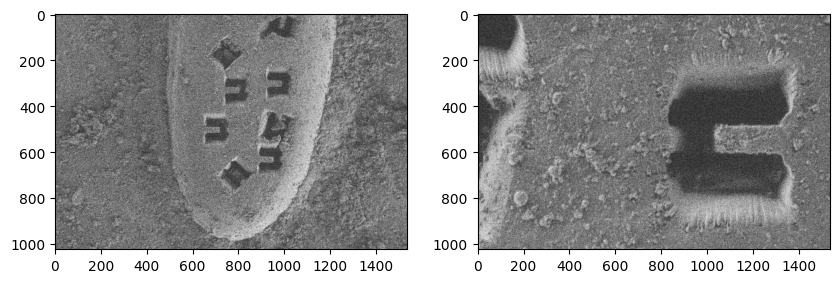

In [74]:
# lamella freq

from fibsem import conversions

import os
path = r"C:\Users\Admin\Github\autoliftout\liftout\log\dm-embryo-08-2022-10-18.10-39-45AM\02-next-bison"


low_res_ib = AdornedImage.load(os.path.join(path, "ref_trench_low_res_ib.tif"))
high_res_ib = AdornedImage.load(os.path.join(path, "ref_trench_high_res_ib.tif"))

h, w = conversions.get_lamella_size_in_pixels(low_res_ib, settings.protocol["lamella"], use_trench_height=True)
print(f"h: {h}, w:{w}")

h, w = conversions.get_lamella_size_in_pixels(high_res_ib, settings.protocol["lamella"], use_trench_height=True)
print(f"h: {h}, w:{w}")

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(low_res_ib.data, cmap="gray")
ax[1].imshow(high_res_ib.data, cmap="gray")
plt.show()

# TODO: convert these sizes to lp, hp values

In [91]:
protocol = {"width": 2e-6, "height": 1e-6, "depth": 2e-6, 
    "number": 3, "offset": 1e-6, 
    "scan_direction": "RightToLeft", 
    "cleaning_cross_section": False,
    "milling_current": 2e-9}


from liftout import patterning 
microscope.patterning.clear_patterns()

from fibsem.structures import Point

patterning.spot_weld_pattern(microscope, protocol, Point(5e-6, -2e-6))

